In [1]:
from lstmad.vrae import VRAE
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from lstmad.lstmae import RecurrentAutoencoder, train_model

import matplotlib.pyplot as plt

RANDOM_SEED = 666

### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 32
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Load data

In [4]:
train_df = pd.read_csv('data/ECG5000_TRAIN.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

test_df = pd.read_csv('data/ECG5000_TEST.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

In [5]:
df = train_df.append(test_df)
df = df.sample(frac=1.0)
df.target -=1
y = df['target']
X = df.drop(labels='target', axis=1)


In [6]:
train_X, val_X, train_y, val_y = train_test_split(
  X, y,
  test_size=0.3,
  random_state=RANDOM_SEED
)

val_X, test_X, val_y, test_y = train_test_split(
  val_X, val_y,
  test_size=0.5, 
  random_state=RANDOM_SEED
)

In [7]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [8]:
train_dataset, seq_len, n_features = create_dataset(train_X)
val_dataset, _, _ = create_dataset(val_X)
test_dataset, _, _ = create_dataset(test_X)


In [9]:
model = RecurrentAutoencoder(seq_len, n_features, device, 8)
model = model.to(device)

In [ ]:
# train_model(model,train_dataset,val_dataset, 50 , device)
# torch.save(model.state_dict(), 'autoencoder.pkl')

In [10]:
model.load_state_dict(torch.load('autoencoder.pkl'))

<All keys matched successfully>

In [11]:
train_errors, validation_errors, test_errors = [], [], []
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()
with torch.no_grad():
    
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        train_errors.append(loss.item())
    
    for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        validation_errors.append(loss.item())
        
    for seq_true in test_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        test_errors.append(loss.item())
        
train_errors = np.array(train_errors)
validation_errors = np.array(validation_errors)
test_errors = np.array(test_errors)

58.79403745888497

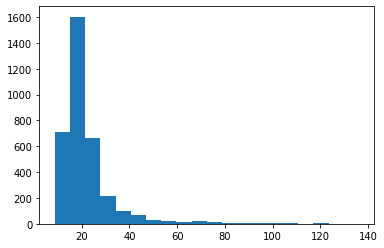

In [12]:
plt.hist(train_errors,bins=20)
train_errors.mean() + 3 * train_errors.std()

57.21844665327109

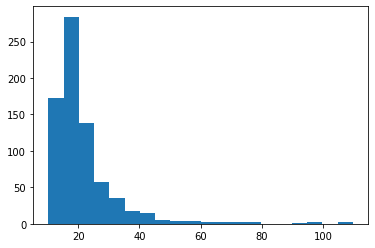

In [13]:
plt.hist(validation_errors,bins=20)
validation_errors.mean() + 3 * validation_errors.std()

65.47623963655548

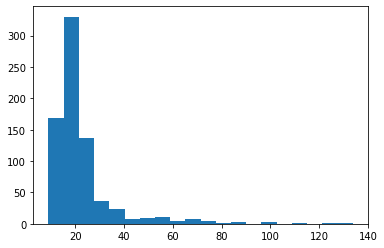

In [14]:
plt.hist(test_errors,bins=20)
test_errors.mean() + 3 * test_errors.std()

In [15]:
val_y.values[validation_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([4., 0., 0., 0., 0., 2., 4., 1., 0., 1., 4., 0., 1., 3., 4., 0.])

In [16]:
test_y.values[test_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 4., 4., 0., 0., 1., 0.,
       4., 3., 2., 0., 3., 0., 0., 2., 1., 0., 0., 1.])

In [17]:
train_y.values[train_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([2., 1., 2., 1., 2., 0., 1., 0., 3., 4., 1., 1., 2., 2., 1., 1., 4.,
       3., 1., 1., 1., 3., 0., 0., 0., 0., 1., 4., 1., 1., 1., 3., 0., 0.,
       0., 4., 0., 1., 0., 1., 0., 0., 0., 0., 3., 2., 2., 0., 1., 1., 0.,
       0., 1., 0., 4., 0., 0., 1., 4., 0., 0., 2., 3., 1., 0., 0., 3., 1.,
       1., 1., 1., 2., 2., 0., 1., 1., 0., 2., 1., 1., 1., 0., 2., 0., 1.,
       2., 2., 2.])

In [18]:
class AnomalyScoreProcessor(nn.Module):

    def __init__(self, autoencoder, autoencoder_latent_dim, hidden_layer_dim, device):
        super(AnomalyScoreProcessor, self).__init__()
        self.autoencoder = autoencoder
        for param in autoencoder.parameters():
            param.requires_grad = False
        self.hidden_layer_dim = hidden_layer_dim
        self.hidden_layer = torch.nn.Linear(autoencoder_latent_dim + 1 , hidden_layer_dim).to(device)
        self.relu = torch.nn.ReLU().to(device)
        self.loss = nn.L1Loss(reduction='sum').to(device)

    def forward(self, x):
        z, out =  self.autoencoder(x)
        anomaly_score = torch.abs(self.loss(out, x))
        concatenated_tensor = torch.cat((z, anomaly_score.reshape(1, 1)), dim=1)
        h = self.hidden_layer(concatenated_tensor)
        rel = self.relu(h)
        return rel

class ExtendedAnomalyDetector(nn.Module):
    
    def __init__(self, anomaly_score_processor, anomaly_score_processor_dim, class_nr, device):
        super(ExtendedAnomalyDetector, self).__init__()
        self.anomaly_score_processor = anomaly_score_processor
        self.output_layer = torch.nn.Linear(anomaly_score_processor_dim, class_nr).to(device)
        self.softmax = torch.nn.Softmax().to(device)
        
    
    def forward(self, x):
        out = self.anomaly_score_processor(x)
        h = self.output_layer(out)
        return self.softmax(h)
   

In [30]:
asp = AnomalyScoreProcessor(model, 8, 4, device)
ead = ExtendedAnomalyDetector(asp, 4, 2, device)

In [36]:
def train_extended_anomaly_detector(model, x_train, y_train, x_val, y_val, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss().to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for seq, y in zip(x_train, y_train):
            optimizer.zero_grad()
            seq = seq.to(device)
            pred = model(seq)
            #print(y)
            loss = criterion(pred, torch.tensor(y).reshape(1).to(device))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq, y in zip(x_val, y_val):
                seq = seq.to(device)
                pred = model(seq)
                class_val = int(y>1)
                loss = criterion(pred, torch.tensor(class_val).reshape(1).to(device))
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [29]:
anomaly_threshold = validation_errors.mean() + 3 * validation_errors.std()
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()
losses = []
training_y = []
with torch.no_grad():
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        losses.append(loss)

In [31]:
indices = np.argsort(losses)
sorted_losses = [losses[i] for i in indices]

In [25]:
i = len(sorted_losses) - 1 
while sorted_losses[i] > anomaly_threshold:
    i-=1
anomalies_cnt = len(sorted_losses) - 1 - i
normal_data_index = i - anomalies_cnt
normal_indices = indices[normal_data_index:i]
anomaly_indices = indices[i:]

artificial_train_dataset_X=[]
artificial_train_dataset_y=[]
labels = []

for idx in normal_indices:
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(0)
    labels.append(train_y.iloc[idx])

for idx in anomaly_indices:
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(1)
    labels.append(train_y.iloc[idx])
artificial_train_dataset_y = pd.Series(artificial_train_dataset_y)

In [26]:
artificial_train_dataset_y.value_counts()

1    89
0    88
dtype: int64

In [48]:
train_extended_anomaly_detector(ead, artificial_train_dataset_X, artificial_train_dataset_y, val_dataset, val_y,200)

<ipython-input-18-77358d5482b9>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(h)


Epoch 1: train loss 0.4717831423053634 val loss 0.39766698026657105
Epoch 2: train loss 0.46625765703492245 val loss 0.39813790758450823
Epoch 3: train loss 0.46634547824913497 val loss 0.3979583479563395
Epoch 4: train loss 0.4655144319022443 val loss 0.3976763834158579
Epoch 5: train loss 0.46460542840472724 val loss 0.39736603291829425
Epoch 6: train loss 0.46369066750262417 val loss 0.3970482778549194
Epoch 7: train loss 0.46278295442882905 val loss 0.39673129765192666
Epoch 8: train loss 0.46188456729307015 val loss 0.3964190068244934
Epoch 9: train loss 0.46099660086766475 val loss 0.39611343065897625
Epoch 10: train loss 0.46011855373274807 val loss 0.39581513047218325
Epoch 11: train loss 0.4592508074253966 val loss 0.39552419980367026
Epoch 12: train loss 0.45839297704103976 val loss 0.3952411892414093
Epoch 13: train loss 0.45754479621089783 val loss 0.3949666330019633
Epoch 14: train loss 0.4567062275557868 val loss 0.39470053537686667
Epoch 15: train loss 0.4558772953216639

KeyboardInterrupt: 

In [49]:
preds = []
ead = ead.eval()
with torch.no_grad():    
    for seq in artificial_train_dataset_X:
        seq = seq.to(device)
        pred = ead(seq)
        pred = np.argmax(pred.cpu().numpy())
        preds.append(pred)
preds = pd.Series(preds)

<ipython-input-18-77358d5482b9>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(h)


In [50]:
sum(artificial_train_dataset_y == preds)/len(preds)

0.8305084745762712

In [44]:
preds.value_counts()

1    123
0     54
dtype: int64

In [ ]:
b=torch.zeros(8, dtype=float).reshape(1,8)

In [ ]:
torch.cat((a.reshape(1),b), axis=0)

In [ ]:
a.reshape(1).shape

In [ ]:
b.shape

In [ ]:
a_reshaped = a.reshape(1,1)

In [ ]:
torch.cat((a_reshaped, b), dim=1)